In [51]:
# 💤 Sleep Quality Prediction - Simple ML Project
# -------------------------------------------------
# 1️⃣ Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



In [52]:
# -------------------------------------------------
# 2️⃣ Create Synthetic Dataset (More Realistic)
import numpy as np
import pandas as pd

np.random.seed(42)
n = 3000  # enough samples for variation

age = np.random.randint(18, 70, n)
gender = np.random.choice(['Male', 'Female'], n)
screen_time = np.round(np.random.uniform(0.5, 6, n), 2)
exercise = np.random.randint(0, 120, n)
stress = np.round(np.random.uniform(1, 10, n), 2)
caffeine = np.random.choice([0, 50, 100, 150, 200, 250], n)
noise = np.random.randint(20, 60, n)

screen_time = screen_time.astype(float)
exercise = exercise.astype(float)
caffeine = caffeine.astype(float)
noise = noise.astype(float)
# 💡 Add controlled randomness (simulating real-world data noise)
screen_time += np.random.normal(0, 0.3, n)
stress += np.random.normal(0, 0.4, n)
exercise += np.random.normal(0, 5, n)
caffeine += np.random.normal(0, 10, n)
noise += np.random.normal(0, 3, n)

# Clip back to valid ranges
screen_time = np.clip(screen_time, 0.5, 6)
stress = np.clip(stress, 1, 10)
exercise = np.clip(exercise, 0, 120)
caffeine = np.clip(caffeine, 0, 250)
noise = np.clip(noise, 20, 60)

# 💤 Sleep Hours formula – softened relationships + random offset
sleep_hours = np.clip(
    8
    - (screen_time * 0.2)
    - (stress * 0.15)
    + (exercise / 120)
    - (caffeine / 600)
    - (noise / 120)
    + np.random.normal(0, 0.6, n),
    3, 10
)


# Sleep quality thresholds
# Introduce some natural variation in how people perceive their sleep
random_shift = np.random.normal(0, 0.3, n)
adjusted_hours = sleep_hours + random_shift

sleep_quality = np.where(
    adjusted_hours >= 7.5, 'Good',
    np.where(adjusted_hours >= 6, 'Moderate', 'Poor')
)

# Final dataframe
df = pd.DataFrame({
    'Age': age,
    'Gender': gender,
    'ScreenTime': screen_time,
    'Exercise': exercise,
    'Stress': stress,
    'Caffeine': caffeine,
    'Noise': noise,
    'SleepHours': sleep_hours,
    'SleepQuality': sleep_quality
})

df.to_csv('sleep_quality.csv', index=False)
print("✅ Realistic synthetic dataset created!")
print(df['SleepQuality'].value_counts())


✅ Realistic synthetic dataset created!
SleepQuality
Moderate    1727
Poor         884
Good         389
Name: count, dtype: int64


In [53]:
# Add random noise to simulate real-world inconsistency
df['ScreenTime'] += np.random.normal(0, 0.3, len(df))
df['Stress'] += np.random.normal(0, 0.4, len(df))
df['Exercise'] += np.random.normal(0, 5, len(df))
df['Caffeine'] += np.random.normal(0, 10, len(df))
df['Noise'] += np.random.normal(0, 3, len(df))

# Clip again to keep values within valid range
df['ScreenTime'] = df['ScreenTime'].clip(0.5, 6)
df['Stress'] = df['Stress'].clip(1, 10)
df['Exercise'] = df['Exercise'].clip(0, 120)
df['Caffeine'] = df['Caffeine'].clip(0, 250)
df['Noise'] = df['Noise'].clip(20, 60)


In [54]:
# -------------------------------------------------
# 4️⃣ Data Understanding
print("\n--- DATA INFO ---")
print(df.info())



--- DATA INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           3000 non-null   int32  
 1   Gender        3000 non-null   object 
 2   ScreenTime    3000 non-null   float64
 3   Exercise      3000 non-null   float64
 4   Stress        3000 non-null   float64
 5   Caffeine      3000 non-null   float64
 6   Noise         3000 non-null   float64
 7   SleepHours    3000 non-null   float64
 8   SleepQuality  3000 non-null   object 
dtypes: float64(6), int32(1), object(2)
memory usage: 199.3+ KB
None


In [55]:
print("\n--- FIRST 5 ROWS ---")
print(df.head())



--- FIRST 5 ROWS ---
   Age  Gender  ScreenTime    Exercise    Stress    Caffeine      Noise  \
0   56    Male    2.973898   58.194547  7.640928   81.069964  55.432893   
1   69  Female    1.792034  105.342842  8.751433   48.011813  29.086554   
2   46    Male    1.059868  109.772550  3.798767  119.111417  21.968701   
3   32    Male    3.582059   80.560258  9.940736  115.359665  40.189041   
4   60  Female    2.596932  105.924686  1.396279  153.637334  20.773773   

   SleepHours SleepQuality  
0    5.842938         Poor  
1    7.505316         Good  
2    8.104967         Good  
3    5.136797         Poor  
4    7.620926         Good  


In [56]:
print("\n--- DESCRIPTIVE STATS ---")
print(df.describe())


--- DESCRIPTIVE STATS ---
               Age   ScreenTime     Exercise       Stress     Caffeine  \
count  3000.000000  3000.000000  3000.000000  3000.000000  3000.000000   
mean     43.563000     3.219983    60.032409     5.461841   125.489810   
std      14.941791     1.602547    34.549321     2.578929    83.341963   
min      18.000000     0.500000     0.000000     1.000000     0.000000   
25%      31.000000     1.845596    30.187694     3.299367    49.824517   
50%      44.000000     3.189128    61.232468     5.431494   127.960062   
75%      56.000000     4.590128    88.547617     7.630616   200.473366   
max      69.000000     6.000000   120.000000    10.000000   250.000000   

             Noise   SleepHours  
count  3000.000000  3000.000000  
mean     39.289208     6.477530  
std      11.707651     0.849852  
min      20.000000     3.785440  
25%      29.369737     5.897178  
50%      38.967466     6.507361  
75%      49.130739     7.079259  
max      60.000000     9.105362  


In [57]:
print("\n--- NULL VALUES ---")
print(df.isnull().sum())



--- NULL VALUES ---
Age             0
Gender          0
ScreenTime      0
Exercise        0
Stress          0
Caffeine        0
Noise           0
SleepHours      0
SleepQuality    0
dtype: int64


In [58]:
print("\n--- VALUE COUNTS ---")
print(df['SleepQuality'].value_counts())


--- VALUE COUNTS ---
SleepQuality
Moderate    1727
Poor         884
Good         389
Name: count, dtype: int64


In [59]:

# -------------------------------------------------
# 5️⃣ Data Visualization (EDA)
sns.set(style='whitegrid', palette='viridis')



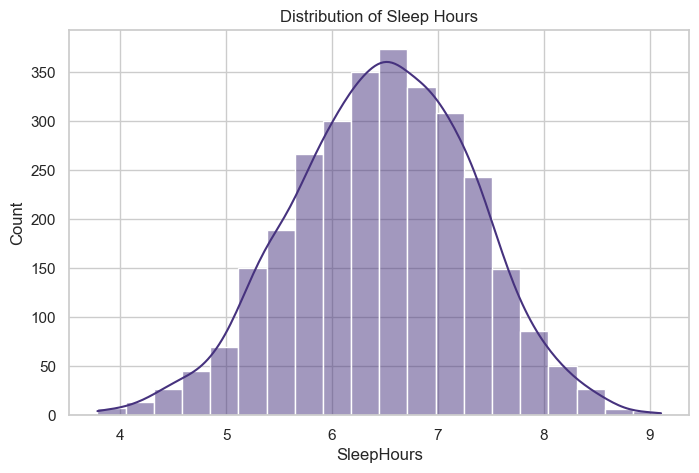

In [60]:
plt.figure(figsize=(8,5))
sns.histplot(df['SleepHours'], kde=True, bins=20)
plt.title("Distribution of Sleep Hours")
plt.savefig('plot_sleep_hours.png')
plt.show()



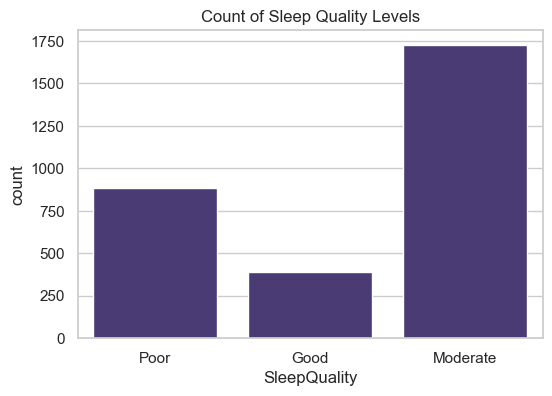

In [61]:

plt.figure(figsize=(6,4))
sns.countplot(x='SleepQuality', data=df)
plt.title("Count of Sleep Quality Levels")
plt.savefig('plot_sleep_quality_count.png')
plt.show()



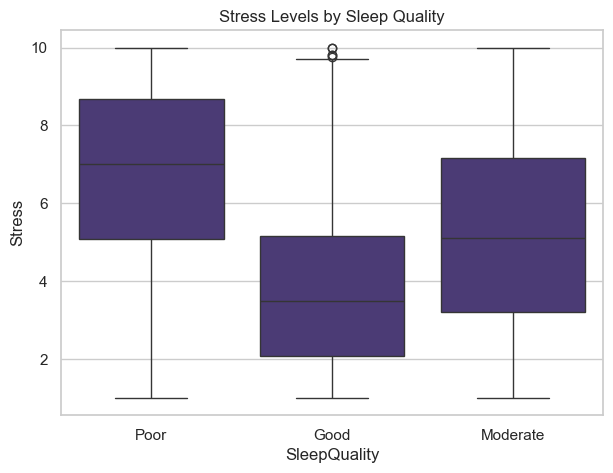

In [62]:
plt.figure(figsize=(7,5))
sns.boxplot(x='SleepQuality', y='Stress', data=df)
plt.title("Stress Levels by Sleep Quality")
plt.savefig('plot_stress_sleepquality.png')
plt.show()



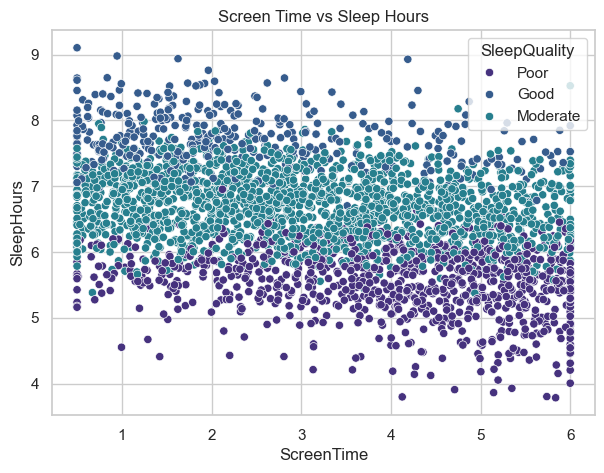

In [63]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='ScreenTime', y='SleepHours', hue='SleepQuality', data=df)
plt.title("Screen Time vs Sleep Hours")
plt.savefig('plot_screen_sleep.png')
plt.show()



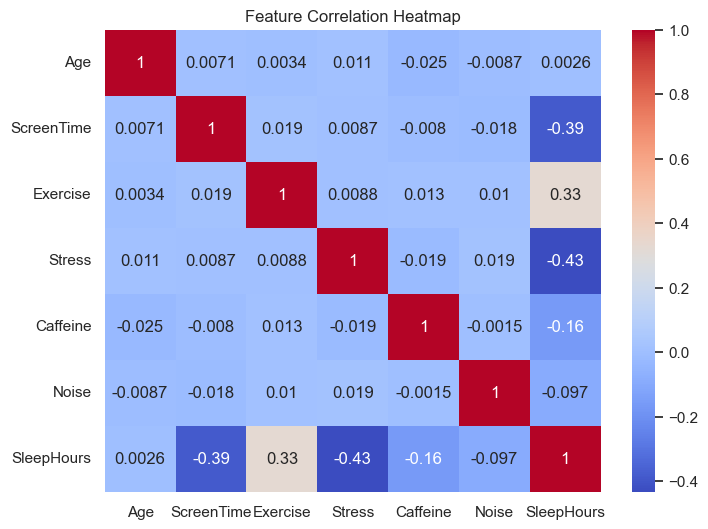

In [64]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.savefig('plot_heatmap.png')
plt.show()

In [65]:

# -------------------------------------------------
# 6️⃣ Feature Engineering
df['CaffeineCategory'] = pd.cut(df['Caffeine'], bins=[-1,50,150,300],
                                labels=['Low','Medium','High'])
df['StressLevel'] = pd.cut(df['Stress'], bins=[0,4,7,10],
                           labels=['Low','Moderate','High'])
df['Active'] = np.where(df['Exercise']>60,1,0)
df['NoiseLevel'] = np.where(df['Noise']>40,'High','Low')

print("\n--- FEATURE ENGINEERING DONE ---")
print(df[['Caffeine','CaffeineCategory','Stress','StressLevel','Exercise','Active','Noise','NoiseLevel']].head())



--- FEATURE ENGINEERING DONE ---
     Caffeine CaffeineCategory    Stress StressLevel    Exercise  Active  \
0   81.069964           Medium  7.640928        High   58.194547       0   
1   48.011813              Low  8.751433        High  105.342842       1   
2  119.111417           Medium  3.798767         Low  109.772550       1   
3  115.359665           Medium  9.940736        High   80.560258       1   
4  153.637334             High  1.396279         Low  105.924686       1   

       Noise NoiseLevel  
0  55.432893       High  
1  29.086554        Low  
2  21.968701        Low  
3  40.189041       High  
4  20.773773        Low  


In [66]:

# Encode categorical variables
df_encoded = df.copy()
label_enc = LabelEncoder()
df_encoded['Gender'] = label_enc.fit_transform(df_encoded['Gender'])
df_encoded['CaffeineCategory'] = label_enc.fit_transform(df_encoded['CaffeineCategory'])
df_encoded['StressLevel'] = label_enc.fit_transform(df_encoded['StressLevel'])
df_encoded['NoiseLevel'] = label_enc.fit_transform(df_encoded['NoiseLevel'])
df_encoded['SleepQuality'] = label_enc.fit_transform(df_encoded['SleepQuality'])


In [67]:

# -------------------------------------------------
# 7️⃣ Train-Test Split
X = df_encoded.drop('SleepQuality', axis=1)
y = df_encoded['SleepQuality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [68]:
# -------------------------------------------------
# 🧮 Balance the Dataset Before Training
from sklearn.utils import resample

# Check original class distribution
print("Before balancing:", df_encoded['SleepQuality'].value_counts())

# Separate classes
df_good = df_encoded[df_encoded['SleepQuality'] == 0]
df_mod = df_encoded[df_encoded['SleepQuality'] == 1]
df_poor = df_encoded[df_encoded['SleepQuality'] == 2]

# Balance by upsampling minority classes
df_balanced = pd.concat([
    resample(df_good, replace=True, n_samples=len(df_mod), random_state=42),
    df_mod,
    resample(df_poor, replace=True, n_samples=len(df_mod), random_state=42)
])

# Shuffle it up
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("After balancing:", df_balanced['SleepQuality'].value_counts())

# Define features/labels again for balanced data
X = df_balanced.drop('SleepQuality', axis=1)
y = df_balanced['SleepQuality']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Before balancing: SleepQuality
1    1727
2     884
0     389
Name: count, dtype: int64
After balancing: SleepQuality
2    1727
1    1727
0    1727
Name: count, dtype: int64


In [69]:

# -------------------------------------------------
# 8️⃣ Model Training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(max_iter=500)
lr.fit(X_train_scaled, y_train)

rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=6,
    min_samples_split=8,
    random_state=42
)
rf.fit(X_train, y_train)



,n_estimators,50
,criterion,'gini'
,max_depth,6
,min_samples_split,8
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [70]:

# -------------------------------------------------
# 9️⃣ Model Evaluation
print("\n--- Logistic Regression ---")
y_pred_lr = lr.predict(X_test_scaled)
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", round(accuracy_score(y_test, y_pred_lr),3))



--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       373
           1       0.77      0.71      0.74       339
           2       0.86      0.92      0.89       325

    accuracy                           0.84      1037
   macro avg       0.83      0.84      0.83      1037
weighted avg       0.83      0.84      0.84      1037

Accuracy: 0.837


In [71]:

print("\n--- Random Forest ---")
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf),3))



--- Random Forest ---
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       373
           1       0.82      0.75      0.79       339
           2       0.88      0.93      0.90       325

    accuracy                           0.87      1037
   macro avg       0.86      0.87      0.86      1037
weighted avg       0.86      0.87      0.86      1037

Accuracy: 0.866


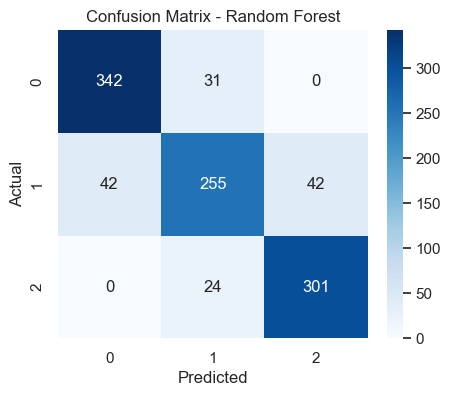

In [72]:

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('plot_confusion_rf.png')
plt.show()


In [73]:

# -------------------------------------------------
# 🔟 Predict on New Data
new_data = pd.DataFrame({
    'Age': [25],
    'Gender': [1],  # 1 for Male (encoded)
    'ScreenTime': [4.5],
    'Exercise': [30],
    'Stress': [8.2],
    'Caffeine': [150],
    'Noise': [50],
    'SleepHours': [5.6],
    'CaffeineCategory': [1],
    'StressLevel': [2],
    'Active': [0],
    'NoiseLevel': [1]
})

# Match features
new_scaled = scaler.transform(new_data)
pred = rf.predict(new_data)
pred_label = label_enc.inverse_transform(pred)
print("\n🧠 Prediction for new data:", pred_label[0])




🧠 Prediction for new data: Poor


In [74]:

# -------------------------------------------------
# 1️⃣1️⃣ Save Models
joblib.dump(lr, 'sleep_lr_model.pkl')
joblib.dump(rf, 'sleep_rf_model.pkl')
joblib.dump(scaler, 'sleep_scaler.pkl')

print("\n✅ Models saved: sleep_lr_model.pkl, sleep_rf_model.pkl, sleep_scaler.pkl")



✅ Models saved: sleep_lr_model.pkl, sleep_rf_model.pkl, sleep_scaler.pkl
